In [57]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
!pip install lightgbm

In [58]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
        "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
        'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
        'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
        'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
        'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
        'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
        'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
        'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
        'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
        's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
        've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
        "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
        'won', "won't", 'wouldn', "wouldn't"]

from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in text_data:
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [59]:
train_data = pd.read_csv('/content/drive/MyDrive/CS2/train.csv/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/CS2/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)

train_data['excerpt'] = preprocess_text(train_data['excerpt'].values)
test_data['excerpt'] = preprocess_text(test_data['excerpt'].values)

#Base Models:

In [60]:
#Appplying LinearRegression:
def linear_regression(x_train,y_train,x_cv,y_cv):
  from sklearn.linear_model import LinearRegression
  clf = LinearRegression()
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print(clf,'mse_tr:',mse_tr,'mse_cv:',mse_cv)
  return clf,mse_tr,mse_cv


In [61]:
def knn_regression(x_train,y_train,x_cv,y_cv):
  from sklearn.neighbors import KNeighborsRegressor
  C_values = [1,5,7,10,15,20]
  mse_list_tr = []
  mse_list_cv = []
  print('/n Hyper Parameter Tuning for KNN:')
  for i in C_values:
      clf = KNeighborsRegressor(n_neighbors=i)
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = KNeighborsRegressor(n_neighbors=best_C)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -KNN Regression')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [62]:
def SVR_Linear(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR Linear:')
  for i in C_values:
      clf = SVR(C=i,kernel='linear')
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='linear')
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -SVR Linear')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [63]:
def SVR_rbf(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1,5,10]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR rbf:')
  for i in C_values:
      clf = SVR(C=i,kernel='rbf')
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='rbf')
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -SVR rbf')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [64]:
def SVR_sigmoid(x_train,y_train,x_cv,y_cv):
  from sklearn.svm import SVR
  C_values = [0.001,0.01,0.1,0.5,1]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for SVR sigmoid:')
  for i in C_values:
      clf = SVR(C=i,kernel='sigmoid')
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_C = C_values[np.argmin(mse_list_cv)]
  clf = SVR(C=best_C,kernel='sigmoid')
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -SVR sigmoid')
  print('\ntrain mse for C=',best_C,'is',mse_tr)
  print('cv mse for C=',best_C,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [65]:
def Decision_Tree(x_train,y_train,x_cv,y_cv):
  #/nHyper parameter Tuning:
  from sklearn.tree import DecisionTreeRegressor

  max_depth_list=[1, 5, 10, 50]
  min_split_list=[5, 10, 100, 500]
  mse_list_tr = []
  mse_list_cv = []
  L=0
  min_loss=0
  p=0
  q=0
  for i in min_split_list:
    for j in max_depth_list:
      clf_dt = DecisionTreeRegressor(max_depth=j,min_samples_split=i)
      clf_dt.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      if L==0:
        min_loss=mse_cv
        L=L+1
        p=i
        q=j
        continue
      if mse_cv<min_loss:
        min_loss=mse_cv
        p=i
        q=j

  #representing Log_Loss values in HEat Maps
  sbn_log_loss_tr=np.reshape(mse_list_tr,(4,4))
  sbn_log_loss_cv=np.reshape(mse_list_cv,(4,4))
  import seaborn as sns
  xticks=[1,5,10,50]
  yticks=[5, 10, 100, 500]

  print('/nHyper Parameter Tuning for Decision Tree:')

  print('Heatmap for log_loss values Train data')
  heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()

  print('\nHeatmap for log_loss values CV data')
  heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()
  print('\nBest Values -Decision Tree')
  print('\ntrain mse for min_split=',p,'and max_depth=',q,' is',mse_tr)
  print('cv mse for min_split=',p,'and max_depth=',q,' is',mse_cv)


  clf = DecisionTreeRegressor(max_depth=q,min_samples_split=p)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))

  return clf,mse_tr,mse_cv

In [66]:
def Random_Forest(x_train,y_train,x_cv,y_cv):
  #/nHyper parameter Tuning:
  from sklearn.ensemble import RandomForestRegressor

  max_depth_list=[1, 5, 10, 50]
  min_split_list=[5, 10, 100, 500]
  mse_list_tr = []
  mse_list_cv = []
  L=0
  min_loss=0
  p=0
  q=0
  for i in min_split_list:
    for j in max_depth_list:
      clf_dt = RandomForestRegressor(max_depth=j,min_samples_split=i)
      clf_dt.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      if L==0:
        min_loss=mse_cv
        L=L+1
        p=i
        q=j
        continue
      if mse_cv<min_loss:
        min_loss=mse_cv
        p=i
        q=j

  #representing Log_Loss values in HEat Maps
  sbn_log_loss_tr=np.reshape(mse_list_tr,(4,4))
  sbn_log_loss_cv=np.reshape(mse_list_cv,(4,4))
  import seaborn as sns
  xticks=[1,5,10,50]
  yticks=[5, 10, 100, 500]

  print('/nHyper Parameter Tuning for Decision Tree:')

  print('Heatmap for log_loss values Train data')
  heat_map_cv = sns.heatmap(sbn_log_loss_tr, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()

  print('\nHeatmap for log_loss values CV data')
  heat_map_cv = sns.heatmap(sbn_log_loss_cv, annot=True,yticklabels=yticks,xticklabels=xticks,fmt='.5f')
  plt.xlabel('max_depth_list')
  plt.ylabel('min_split_list')
  plt.show()
  print('\nBest Values -RandomForestRegressor:')
  print('\ntrain mse for min_split=',p,'and max_depth=',q,' is',mse_tr)
  print('cv mse for min_split=',p,'and max_depth=',q,' is',mse_cv)


  clf = RandomForestRegressor(max_depth=q,min_samples_split=p)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf_dt.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf_dt.predict(x_cv))

  return clf,mse_tr,mse_cv

In [67]:
def CatBoost(x_train,y_train,x_cv,y_cv):
  !pip install catboost
  from catboost import CatBoostRegressor

  n_est=[10,50,100,250,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for CatBoost:')
  for i in n_est:
      #clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.1,depth=10,task_type="GPU")
      clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.2)
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for iterations=',i,'is',mse_cv)

  best_i = n_est[np.argmin(mse_list_cv)]
  #clf = CatBoostRegressor(verbose=0, iterations=best_i,learning_rate=0.1,depth=10,task_type="GPU")
  clf = CatBoostRegressor(verbose=0, iterations=i,learning_rate=0.2)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -CatBoost')
  print('\ntrain mse for C=',best_i,'is',mse_tr)
  print('cv mse for iterations=',best_i,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [68]:
def Light_gbm(x_train,y_train,x_cv,y_cv):
  #!pip install lightgbm
  from lightgbm import LGBMRegressor
  n_est = [10,50,100,350,400,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for Light_gbm:')
  for i in n_est:
      clf = LGBMRegressor(verbose=0, n_estimators=i,random_state=10)
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_iter = n_est[np.argmin(mse_list_cv)]
  clf = LGBMRegressor(verbose=0, n_estimators=best_iter,random_state=10)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -Light_gbm')
  print('\ntrain mse for estimators=',best_iter,'is',mse_tr)
  print('cv mse for estimators=',best_iter,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [69]:
def xgboost(x_train,y_train,x_cv,y_cv):
  import xgboost as xg
  n_est = [10,50,100,350,400,500]
  mse_list_tr = []
  mse_list_cv = []
  print('/nHyper Parameter Tuning for xgboost:')
  for i in n_est:
      clf = xg.XGBRegressor(verbose=0, n_estimators=i,random_state=10)
      clf.fit(x_train,y_train)
      mse_tr=mean_squared_error(y_train,clf.predict(x_train))
      mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
      mse_list_tr.append(mse_tr)
      mse_list_cv.append(mse_cv)
      print('cv mse for C=',i,'is',mse_cv)

  best_iter = n_est[np.argmin(mse_list_cv)]
  clf = xg.XGBRegressor(verbose=0, n_estimators=best_iter,random_state=10)
  clf.fit(x_train,y_train)
  mse_tr=mean_squared_error(y_train,clf.predict(x_train))
  mse_cv=mean_squared_error(y_cv,clf.predict(x_cv))
  print('\nBest Values -xgboost')
  print('\ntrain mse for estimators=',best_iter,'is',mse_tr)
  print('cv mse for estimators=',best_iter,'is',mse_cv)
  return clf,mse_tr,mse_cv

In [70]:
def neural_network(x_train,y_train,x_cv,y_cv):
  import tensorflow as tf
  from keras.callbacks import EarlyStopping,TensorBoard
  early_stop_1=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation, BatchNormalization,Input,PReLU
  from keras.utils import np_utils
  from keras.optimizers import Adam
  from keras.models import Model
  from keras.optimizers import Adagrad


  def model_1(input_shape):
      model = Sequential()
      model.add(Dense(256, input_dim=input_shape))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      model.add(Dense(64))
      model.add(PReLU())
      model.add(BatchNormalization())
      model.add(Dropout(0.25))
      model.add(Dense(1))
      model.add(Activation('linear'))
      model.compile(loss='MeanSquaredError',
                optimizer='adam',
                metrics=['MeanSquaredError'])
      return model
  x_t=pd.DataFrame(x_train)
  y_t=pd.DataFrame(y_train)
  x_cvt=pd.DataFrame(x_cv)
  y_cvt=pd.DataFrame(y_cv)
  nnmodels=20
  model_list=[]
  for i in range(nnmodels):
    x_tr_nn, x_cv_nn, y_tr_nn, y_cv_nn = train_test_split(x_t, y_t, test_size=0.15,random_state=i*10)
    model=model_1(x_tr_nn.shape[1])
    model.fit(x_tr_nn, y_tr_nn, batch_size=50, epochs=50, verbose=0, validation_data=(x_cv_nn,y_cv_nn),callbacks=[early_stop_1])
    model_list.append(model)



  y_tr_pred=np.zeros((x_t.shape[0],1))
  y_cv_pred=np.zeros((x_cvt.shape[0],1))

  for i in range(nnmodels):
    y_cv_pred=y_cv_pred+model_list[i].predict(x_cvt)
    y_tr_pred=y_tr_pred+model_list[i].predict(x_t)

  y_cv_pred=y_cv_pred/nnmodels
  y_tr_pred=y_tr_pred/nnmodels

  mse_tr=mean_squared_error(y_t,y_tr_pred)
  mse_cv=mean_squared_error(y_cvt,y_cv_pred)
  return model_list,mse_tr,mse_cv

#Applying avgw2v

In [71]:
#Applying Pretrained Model for vectorization: Avg W2V
from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15)



import pickle
with open('/content/drive/MyDrive/Copy of glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

def avgw2v_proc(data):

  # average Word2Vec
  # compute average word2vec for each review.
  avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in data: # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words:
              vector += model[word]
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      avg_w2v_vectors.append(vector)
  return avg_w2v_vectors

x_train=avgw2v_proc(x_train)
x_test=avgw2v_proc(x_test)
x_cv=avgw2v_proc(x_cv)
test_data_vect=avgw2v_proc(test_data['excerpt'])

/nHyper Parameter Tuning for xgboost:
[22:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 10 is 1.0163882075467237
[22:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 50 is 0.5523299766644802
[22:36:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 100 is 0.5138374966958666
[22:36:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 350 is 0.5116868411848334
[22:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 400 is 0.5099946728990638
[22:37:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv

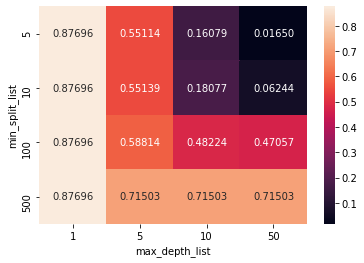


Heatmap for log_loss values CV data


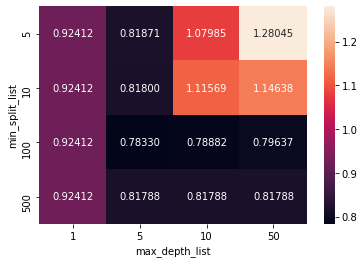


Best Values -Decision Tree

train mse for min_split= 100 and max_depth= 5  is 0.7150294011902204
cv mse for min_split= 100 and max_depth= 5  is 0.8178765234705919
/nHyper Parameter Tuning for Decision Tree:
Heatmap for log_loss values Train data


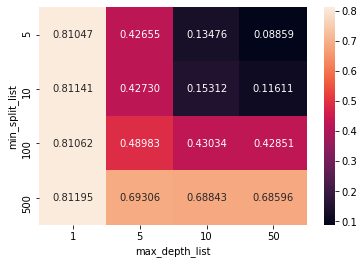


Heatmap for log_loss values CV data


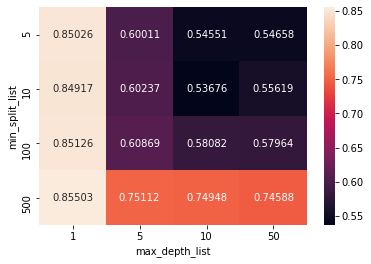


Best Values -RandomForestRegressor:

train mse for min_split= 10 and max_depth= 10  is 0.6859645535585664
cv mse for min_split= 10 and max_depth= 10  is 0.7458813034985873
/nHyper Parameter Tuning for Light_gbm:
cv mse for C= 10 is 0.6660804858752796
cv mse for C= 50 is 0.5095641935870658
cv mse for C= 100 is 0.5016543878399544
cv mse for C= 350 is 0.499790822185149
cv mse for C= 400 is 0.49983883750009905
cv mse for C= 500 is 0.49982567193611144

Best Values -Light_gbm

train mse for estimators= 350 is 0.00013398784912845596
cv mse for estimators= 350 is 0.499790822185149
/nHyper Parameter Tuning for CatBoost:
cv mse for iterations= 10 is 0.6483055844314821
cv mse for iterations= 50 is 0.5176369866896791
cv mse for iterations= 100 is 0.5082424075699759
cv mse for iterations= 250 is 0.49945289606135684
cv mse for iterations= 500 is 0.49944102138923574

Best Values -CatBoost

train mse for C= 500 is 0.0002435708959653533
cv mse for iterations= 500 is 0.49944102138923574


In [73]:
clf_xg_avgw2v,mse_tr_xg_avgw2v,mse_cv_xg_avgw2v=xgboost(x_train,y_train,x_cv,y_cv)

clf_lr_avgw2v,mse_tr_lr_avgw2v,mse_cv_lr_avgw2v=linear_regression(x_train,y_train,x_cv,y_cv)

clf_knn_avgw2v,mse_tr_knn_avgw2v,mse_cv_knn_avgw2v=knn_regression(x_train,y_train,x_cv,y_cv)

clf_svrlr_avgw2v,mse_tr_svrlr_avgw2v,mse_cv_svrlr_avgw2v=SVR_Linear(x_train,y_train,x_cv,y_cv)

clf_svrrbf_avgw2v,mse_tr_svrrbf_avgw2v,mse_cv_svrrbf_avgw2v=SVR_rbf(x_train,y_train,x_cv,y_cv)

clf_svrsig_avgw2v,mse_tr_svrsig_avgw2v,mse_cv_svrsig_avgw2v=SVR_sigmoid(x_train,y_train,x_cv,y_cv)

clf_dt_avgw2v,mse_tr_dt_avgw2v,mse_cv_dt_avgw2v=Decision_Tree(x_train,y_train,x_cv,y_cv)

clf_rf_avgw2v,mse_tr_rf_avgw2v,mse_cv_rf_avgw2v=Random_Forest(x_train,y_train,x_cv,y_cv)

clf_lgbm_avgw2v,mse_tr_lgbm_avgw2v,mse_cv_lgbm_avgw2v=Light_gbm(x_train,y_train,x_cv,y_cv)

clf_cb_avgw2v,mse_tr_cb_avgw2v,mse_cv_cb_avgw2v=CatBoost(x_train,y_train,x_cv,y_cv)



clf_nn_avgw2v,mse_tr_nn_avgw2v,mse_cv_nn_avgw2v=neural_network(x_train,y_train,x_cv,y_cv)


In [74]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models","Train MSE", " CV MSE"]
pt.add_row(["Linear Regression",  mse_tr_lr_avgw2v,mse_cv_lr_avgw2v])
pt.add_row(["KNN Regression",  mse_tr_knn_avgw2v,mse_cv_knn_avgw2v])
pt.add_row(["SVR Linear",  mse_tr_svrlr_avgw2v,mse_cv_svrlr_avgw2v])
pt.add_row(["SVR RBF",  mse_tr_svrrbf_avgw2v,mse_cv_svrrbf_avgw2v])
pt.add_row(["SVR Sigmoid",  mse_tr_svrsig_avgw2v,mse_cv_svrsig_avgw2v])
pt.add_row(["Decision Tree",   mse_tr_dt_avgw2v,mse_cv_dt_avgw2v])
pt.add_row(["Random Forest Classifier",  mse_tr_rf_avgw2v,mse_cv_rf_avgw2v ])
pt.add_row(["LGBM Classifier",  mse_tr_lgbm_avgw2v,mse_cv_lgbm_avgw2v])
pt.add_row(["XGBoost", mse_tr_xg_avgw2v,mse_cv_xg_avgw2v])
pt.add_row(["CatBoost", mse_tr_cb_avgw2v,mse_cv_cb_avgw2v])
pt.add_row(["Neural Network", mse_tr_nn_avgw2v,mse_cv_nn_avgw2v])
print(pt)

+--------------------------+------------------------+---------------------+
|          Models          |       Train MSE        |        CV MSE       |
+--------------------------+------------------------+---------------------+
|    Linear Regression     |  0.39435630176646236   |  0.5005863319017616 |
|      KNN Regression      |   0.5584823040043013   |  0.6245715996584887 |
|        SVR Linear        |   0.4558032363860127   |  0.4631588955202657 |
|         SVR RBF          |  0.33635482946476764   |  0.4408191724928088 |
|       SVR Sigmoid        |   0.7072980425127096   |  0.7517062674188758 |
|      Decision Tree       |   0.7150294011902204   |  0.8178765234705919 |
| Random Forest Classifier |   0.6859645535585664   |  0.7458813034985873 |
|     LGBM Classifier      | 0.00013398784912845596 |  0.499790822185149  |
|         XGBoost          |  0.045079066223783264  |  0.5099946728990638 |
|         CatBoost         | 0.0002435708959653533  | 0.49944102138923574 |
|      Neura

In [86]:
#Using the Best Models

#**SVR RBG
#**CatBoost
#**neural_network

x_tt=pd.DataFrame(x_test)
y_tt=pd.DataFrame(y_test)

model_list=clf_nn_avgw2v
y_test_nn=np.zeros((x_tt.shape[0],1))
for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_avgw2v.predict(x_test)
y_test_cb=clf_cb_avgw2v.predict(x_test)

In [87]:
w1=0.4
w2=0.2
w3=0.4

y_pred=w1*y_test_svrrbf +w2*y_test_cb +w3*y_test_nn1
MSE_AVG_W2V=mean_squared_error(y_pred,y_test)
print('Applying AVGW2V test data mse:',mean_squared_error(y_pred,y_test))

Applying AVGW2V test data mse: 0.41940277496640177


#Applying BOW

In [15]:
from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15)


vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_cv = vectorizer.transform(x_cv)
x_test = vectorizer.transform(x_test)
test_data_vect = vectorizer.transform(test_data['excerpt'])

     |████████████████████████████████| 69.2MB 50kB/s 
/nHyper Parameter Tuning for CatBoost:
cv mse for iterations= 10 is 0.9181379168300642
cv mse for iterations= 50 is 0.764098686607616
cv mse for iterations= 100 is 0.7329448540037113
cv mse for iterations= 250 is 0.711233327526284
cv mse for iterations= 500 is 0.7134699439184068

Best Values -CatBoost

train mse for C= 250 is 0.05634911932438394
cv mse for iterations= 250 is 0.7134699439184068
/nHyper Parameter Tuning for xgboost:
[21:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 10 is 1.1766740054372615
[21:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 50 is 0.8129027641656594
[21:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 100 is 0.7708719537327209
[21:09:34] 

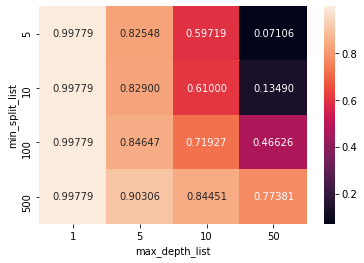


Heatmap for log_loss values CV data


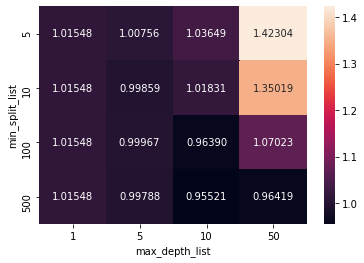


Best Values -Decision Tree

train mse for min_split= 500 and max_depth= 10  is 0.7738133321253596
cv mse for min_split= 500 and max_depth= 10  is 0.9641948305876634
/nHyper Parameter Tuning for Decision Tree:
Heatmap for log_loss values Train data


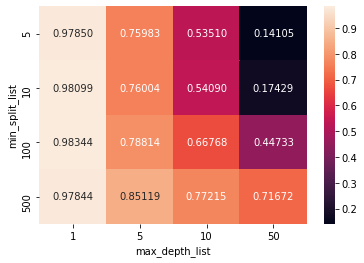


Heatmap for log_loss values CV data


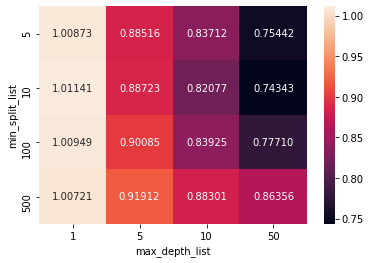


Best Values -RandomForestRegressor:

train mse for min_split= 10 and max_depth= 50  is 0.7167195782045278
cv mse for min_split= 10 and max_depth= 50  is 0.8635575746218555


In [17]:
#clf_lgbm_bow,mse_tr_lgbm_bow,mse_cv_lgbm_bow=Light_gbm(x_train,y_train,x_cv,y_cv)

clf_cb_bow,mse_tr_cb_bow,mse_cv_cb_bow=CatBoost(x_train,y_train,x_cv,y_cv)

clf_xg_bow,mse_tr_xg_bow,mse_cv_xg_bow=xgboost(x_train,y_train,x_cv,y_cv)

clf_lr_bow,mse_tr_lr_bow,mse_cv_lr_bow=linear_regression(x_train,y_train,x_cv,y_cv)

clf_knn_bow,mse_tr_knn_bow,mse_cv_knn_bow=knn_regression(x_train,y_train,x_cv,y_cv)

clf_svrlr_bow,mse_tr_svrlr_bow,mse_cv_svrlr_bow=SVR_Linear(x_train,y_train,x_cv,y_cv)

clf_svrrbf_bow,mse_tr_svrrbf_bow,mse_cv_svrrbf_bow=SVR_rbf(x_train,y_train,x_cv,y_cv)

clf_svrsig_bow,mse_tr_svrsig_bow,mse_cv_svrsig_bow=SVR_sigmoid(x_train,y_train,x_cv,y_cv)

clf_dt_bow,mse_tr_dt_bow,mse_cv_dt_bow=Decision_Tree(x_train,y_train,x_cv,y_cv)

clf_rf_bow,mse_tr_rf_bow,mse_cv_rf_bow=Random_Forest(x_train,y_train,x_cv,y_cv)



clf_nn_bow,mse_tr_nn_bow,mse_cv_nn_bow=neural_network(x_train.toarray(),y_train,x_cv.toarray(),y_cv)

In [18]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models","Train MSE", " CV MSE"]
pt.add_row(["Linear Regression",  mse_tr_lr_bow,mse_cv_lr_bow])
pt.add_row(["KNN Regression",  mse_tr_knn_bow,mse_cv_knn_bow])
pt.add_row(["SVR Linear",  mse_tr_svrlr_bow,mse_cv_svrlr_bow])
pt.add_row(["SVR RBF",  mse_tr_svrrbf_bow,mse_cv_svrrbf_bow])
pt.add_row(["SVR Sigmoid",  mse_tr_svrsig_bow,mse_cv_svrsig_bow])
pt.add_row(["Decision Tree",   mse_tr_dt_bow,mse_cv_dt_bow])
pt.add_row(["Random Forest Classifier",  mse_tr_rf_bow,mse_cv_rf_bow ])
pt.add_row(["XGBoost", mse_tr_xg_bow,mse_cv_xg_bow])
pt.add_row(["CatBoost", mse_tr_cb_bow,mse_cv_cb_bow])
pt.add_row(["Neural Network", mse_tr_nn_bow,mse_cv_nn_bow])
print(pt)

+--------------------------+-----------------------+--------------------+
|          Models          |       Train MSE       |       CV MSE       |
+--------------------------+-----------------------+--------------------+
|    Linear Regression     | 8.299992179039267e-14 | 0.7204645854227754 |
|      KNN Regression      |   0.8034716047238635  | 0.9641108466956386 |
|        SVR Linear        |  0.09283402372520584  | 0.6466519716574067 |
|         SVR RBF          |  0.009265776783007568 |  0.62488736594286  |
|       SVR Sigmoid        |   0.3766684196714603  | 0.6463742531532528 |
|      Decision Tree       |   0.7738133321253596  | 0.9641948305876634 |
| Random Forest Classifier |   0.7167195782045278  | 0.8635575746218555 |
|         XGBoost          |  0.21911406361138666  | 0.7363562563908238 |
|         CatBoost         |  0.05634911932438394  | 0.7134699439184068 |
|      Neural Network      |  0.02205151894178378  | 0.6203725501616532 |
+--------------------------+----------

In [21]:
#Using the Best Models

#**SVR RBG
#**CatBoost
#**neural_network

x_tt=pd.DataFrame(x_test.toarray())
y_tt=pd.DataFrame(y_test)

model_list=clf_nn_bow
y_test_nn=np.zeros((x_tt.shape[0],1))
for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_bow.predict(x_test)
y_test_cb=clf_cb_bow.predict(x_test)

In [31]:
w1=0.3
w2=0.3
w3=0.4

y_pred=w1*y_test_svrrbf +w2*y_test_cb +w3*y_test_nn1
MSE_BOW=mean_squared_error(y_pred,y_test)
print('Applying BOW test data mse:',mean_squared_error(y_pred,y_test))

Applying BOW test data mse: 0.5704705657168644


#Applying TFIDF VEctorizer:

In [16]:
from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_cv = vectorizer.transform(x_cv)
x_test = vectorizer.transform(x_test)
test_data_vect = vectorizer.transform(test_data['excerpt'])

/nHyper Parameter Tuning for Light_gbm:
cv mse for C= 10 is 0.8597805976290832
cv mse for C= 50 is 0.699880549259632
cv mse for C= 100 is 0.7003580107129459
cv mse for C= 350 is 0.7141228742011276
cv mse for C= 400 is 0.715794454818008
cv mse for C= 500 is 0.7176021286355002

Best Values -Light_gbm

train mse for estimators= 50 is 0.2249953571532433
cv mse for estimators= 50 is 0.699880549259632
/nHyper Parameter Tuning for xgboost:
[21:30:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 10 is 1.218568499193024
[21:30:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 50 is 0.8147030837926964
[21:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 100 is 0.7427811023602814
[21:30:48] WARNING: /workspace/src/objective/regression_obj.cu:15

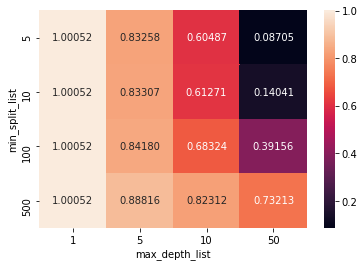


Heatmap for log_loss values CV data


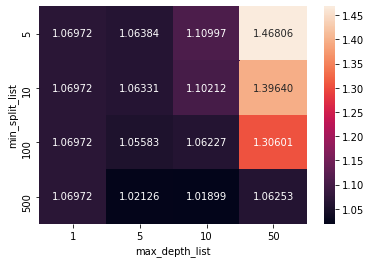


Best Values -Decision Tree

train mse for min_split= 500 and max_depth= 10  is 0.7321262724314154
cv mse for min_split= 500 and max_depth= 10  is 1.0625307947104812
/nHyper Parameter Tuning for Decision Tree:
Heatmap for log_loss values Train data


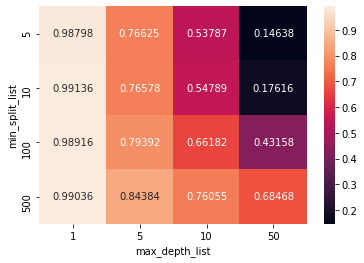


Heatmap for log_loss values CV data


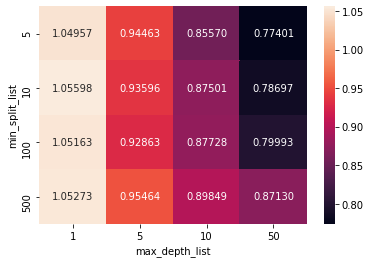


Best Values -RandomForestRegressor:

train mse for min_split= 5 and max_depth= 50  is 0.6846844290531663
cv mse for min_split= 5 and max_depth= 50  is 0.8713004884438427


In [17]:
clf_lgbm_tfidf,mse_tr_lgbm_tfidf,mse_cv_lgbm_tfidf=Light_gbm(x_train,y_train,x_cv,y_cv)

#clf_cb_tfidf,mse_tr_cb_tfidf,mse_cv_cb_tfidf=CatBoost(x_train,y_train,x_cv,y_cv)

clf_xg_tfidf,mse_tr_xg_tfidf,mse_cv_xg_tfidf=xgboost(x_train,y_train,x_cv,y_cv)

clf_lr_tfidf,mse_tr_lr_tfidf,mse_cv_lr_tfidf=linear_regression(x_train,y_train,x_cv,y_cv)

clf_knn_tfidf,mse_tr_knn_tfidf,mse_cv_knn_tfidf=knn_regression(x_train,y_train,x_cv,y_cv)

clf_svrlr_tfidf,mse_tr_svrlr_tfidf,mse_cv_svrlr_tfidf=SVR_Linear(x_train,y_train,x_cv,y_cv)

clf_svrrbf_tfidf,mse_tr_svrrbf_tfidf,mse_cv_svrrbf_tfidf=SVR_rbf(x_train,y_train,x_cv,y_cv)

clf_svrsig_tfidf,mse_tr_svrsig_tfidf,mse_cv_svrsig_tfidf=SVR_sigmoid(x_train,y_train,x_cv,y_cv)

clf_dt_tfidf,mse_tr_dt_tfidf,mse_cv_dt_tfidf=Decision_Tree(x_train,y_train,x_cv,y_cv)

clf_rf_tfidf,mse_tr_rf_tfidf,mse_cv_rf_tfidf=Random_Forest(x_train,y_train,x_cv,y_cv)



clf_nn_tfidf,mse_tr_nn_tfidf,mse_cv_nn_tfidf=neural_network(x_train.toarray(),y_train,x_cv.toarray(),y_cv)

In [18]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models","Train MSE", " CV MSE"]
pt.add_row(["Linear Regression",  mse_tr_lr_tfidf,mse_cv_lr_tfidf])
pt.add_row(["KNN Regression",  mse_tr_knn_tfidf,mse_cv_knn_tfidf])
pt.add_row(["SVR Linear",  mse_tr_svrlr_tfidf,mse_cv_svrlr_tfidf])
pt.add_row(["SVR RBF",  mse_tr_svrrbf_tfidf,mse_cv_svrrbf_tfidf])
pt.add_row(["SVR Sigmoid",  mse_tr_svrsig_tfidf,mse_cv_svrsig_tfidf])
pt.add_row(["Decision Tree",   mse_tr_dt_tfidf,mse_cv_dt_tfidf])
pt.add_row(["Random Forest Classifier",  mse_tr_rf_tfidf,mse_cv_rf_tfidf ])
pt.add_row(["XGBoost", mse_tr_xg_tfidf,mse_cv_xg_tfidf])
#pt.add_row(["CatBoost", mse_tr_cb_tfidf,mse_cv_cb_tfidf])
pt.add_row(["LGBM Classifier",  mse_tr_lgbm_tfidf,mse_cv_lgbm_tfidf])
pt.add_row(["Neural Network", mse_tr_nn_tfidf,mse_cv_nn_tfidf])
print(pt)

+--------------------------+-----------------------+--------------------+
|          Models          |       Train MSE       |       CV MSE       |
+--------------------------+-----------------------+--------------------+
|    Linear Regression     | 7.117269864837328e-15 | 0.666796938050774  |
|      KNN Regression      |   0.693871262853314   | 0.8601926171557541 |
|        SVR Linear        |  0.07838171510675163  | 0.6090291540525089 |
|         SVR RBF          |  0.009277048989533873 | 0.6537445778308539 |
|       SVR Sigmoid        |  0.29895014150614574  | 0.6073342684745263 |
|      Decision Tree       |   0.7321262724314154  | 1.0625307947104812 |
| Random Forest Classifier |   0.6846844290531663  | 0.8713004884438427 |
|         XGBoost          |  0.17448460188706194  | 0.6717486973672299 |
|     LGBM Classifier      |   0.2249953571532433  | 0.699880549259632  |
|      Neural Network      |   0.1595553681617655  | 0.8275445511655536 |
+--------------------------+----------

In [22]:
#Using the Best Models

#**SVR RBG
#**CatBoost
#**neural_network

x_tt=pd.DataFrame(x_test.toarray())
y_tt=pd.DataFrame(y_test)

model_list=clf_nn_tfidf
y_test_nn=np.zeros((x_tt.shape[0],1))
for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrlr=clf_svrlr_tfidf.predict(x_test)
y_test_sig=clf_svrsig_tfidf.predict(x_test)

In [38]:
w1=0.3
w2=0.5
w3=0.2

y_pred=w1*y_test_svrlr +w2*y_test_sig +w3*y_test_nn1
MSE_TFIDF=mean_squared_error(y_pred,y_test)
print('Applying TFIDF test data mse:',mean_squared_error(y_pred,y_test))

Applying TFIDF test data mse: 0.5409363033028497


# Applying Pretrained Models: TFIDF weighted W2V

In [ ]:
#Applying Pretrained Model for vectorization: Avg W2V
from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15)


tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

import pickle
with open('/content/drive/MyDrive/Copy of glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:

def tfidf_w2v_proc(data):
  # average Word2Vec
  tfidf_w2v_vectors = []; # the avg-w2v for each excerpt is stored in this list
  for sentence in data: # for each review/sentence
      vector = np.zeros(300) # as word vectors are of zero length
      tf_idf_weight =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if (word in glove_words) and (word in tfidf_words):
              vec = model[word] # getting the vector for each word
              # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
      if tf_idf_weight != 0:
          vector /= tf_idf_weight
      tfidf_w2v_vectors.append(vector)
  return tfidf_w2v_vectors

x_train=tfidf_w2v_proc(x_train)
x_test=tfidf_w2v_proc(x_test)
x_cv=tfidf_w2v_proc(x_cv)
test_data_vect=tfidf_w2v_proc(test_data['excerpt'])

/nHyper Parameter Tuning for Light_gbm:
cv mse for C= 10 is 0.7846627567284702
cv mse for C= 50 is 0.6022184188555354
cv mse for C= 100 is 0.6050215790577896
cv mse for C= 350 is 0.6033319786112836
cv mse for C= 400 is 0.6032876676634785
cv mse for C= 500 is 0.6032779443782753

Best Values -Light_gbm

train mse for estimators= 50 is 0.09466003126861043
cv mse for estimators= 50 is 0.6022184188555354
/nHyper Parameter Tuning for CatBoost:
cv mse for iterations= 10 is 0.7485582531376073
cv mse for iterations= 50 is 0.6304235871292221
cv mse for iterations= 100 is 0.6295501814320877
cv mse for iterations= 250 is 0.6246819082724293
cv mse for iterations= 500 is 0.6237465682608868

Best Values -CatBoost

train mse for C= 500 is 6.755368948321318e-05
cv mse for iterations= 500 is 0.6237465682608868
/nHyper Parameter Tuning for xgboost:
[22:12:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cv mse for C= 10 is 1.168548998

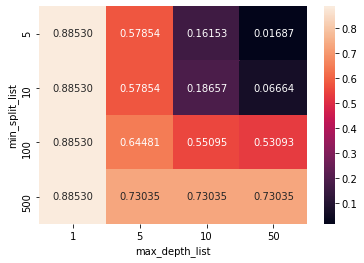


Heatmap for log_loss values CV data


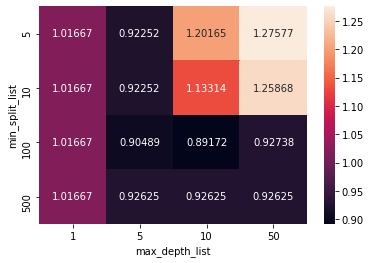


Best Values -Decision Tree

train mse for min_split= 100 and max_depth= 10  is 0.7303549915532292
cv mse for min_split= 100 and max_depth= 10  is 0.926250074836405
/nHyper Parameter Tuning for Decision Tree:
Heatmap for log_loss values Train data


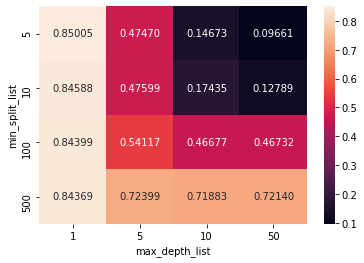


Heatmap for log_loss values CV data


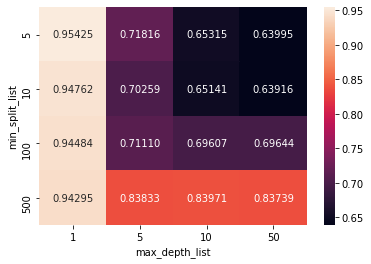


Best Values -RandomForestRegressor:

train mse for min_split= 10 and max_depth= 50  is 0.7213967578813062
cv mse for min_split= 10 and max_depth= 50  is 0.8373875372674385


In [45]:
clf_lgbm_tfidf_w2v,mse_tr_lgbm_tfidf_w2v,mse_cv_lgbm_tfidf_w2v=Light_gbm(x_train,y_train,x_cv,y_cv)

clf_cb_tfidf_w2v,mse_tr_cb_tfidf_w2v,mse_cv_cb_tfidf_w2v=CatBoost(x_train,y_train,x_cv,y_cv)

clf_xg_tfidf_w2v,mse_tr_xg_tfidf_w2v,mse_cv_xg_tfidf_w2v=xgboost(x_train,y_train,x_cv,y_cv)

clf_lr_tfidf_w2v,mse_tr_lr_tfidf_w2v,mse_cv_lr_tfidf_w2v=linear_regression(x_train,y_train,x_cv,y_cv)

clf_knn_tfidf_w2v,mse_tr_knn_tfidf_w2v,mse_cv_knn_tfidf_w2v=knn_regression(x_train,y_train,x_cv,y_cv)

clf_svrlr_tfidf_w2v,mse_tr_svrlr_tfidf_w2v,mse_cv_svrlr_tfidf_w2v=SVR_Linear(x_train,y_train,x_cv,y_cv)

clf_svrrbf_tfidf_w2v,mse_tr_svrrbf_tfidf_w2v,mse_cv_svrrbf_tfidf_w2v=SVR_rbf(x_train,y_train,x_cv,y_cv)

clf_svrsig_tfidf_w2v,mse_tr_svrsig_tfidf_w2v,mse_cv_svrsig_tfidf_w2v=SVR_sigmoid(x_train,y_train,x_cv,y_cv)

clf_dt_tfidf_w2v,mse_tr_dt_tfidf_w2v,mse_cv_dt_tfidf_w2v=Decision_Tree(x_train,y_train,x_cv,y_cv)

clf_rf_tfidf_w2v,mse_tr_rf_tfidf_w2v,mse_cv_rf_tfidf_w2v=Random_Forest(x_train,y_train,x_cv,y_cv)



clf_nn_tfidf_w2v,mse_tr_nn_tfidf_w2v,mse_cv_nn_tfidf_w2v=neural_network(x_train,y_train,x_cv,y_cv)

In [46]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Models","Train MSE", " CV MSE"]
pt.add_row(["Linear Regression",  mse_tr_lr_tfidf_w2v,mse_cv_lr_tfidf_w2v])
pt.add_row(["KNN Regression",  mse_tr_knn_tfidf_w2v,mse_cv_knn_tfidf_w2v])
pt.add_row(["SVR Linear",  mse_tr_svrlr_tfidf_w2v,mse_cv_svrlr_tfidf_w2v])
pt.add_row(["SVR RBF",  mse_tr_svrrbf_tfidf_w2v,mse_cv_svrrbf_tfidf_w2v])
pt.add_row(["SVR Sigmoid",  mse_tr_svrsig_tfidf_w2v,mse_cv_svrsig_tfidf_w2v])
pt.add_row(["Decision Tree",   mse_tr_dt_tfidf_w2v,mse_cv_dt_tfidf_w2v])
pt.add_row(["Random Forest Classifier",  mse_tr_rf_tfidf_w2v,mse_cv_rf_tfidf_w2v ])
pt.add_row(["XGBoost", mse_tr_xg_tfidf_w2v,mse_cv_xg_tfidf_w2v])
pt.add_row(["CatBoost", mse_tr_cb_tfidf_w2v,mse_cv_cb_tfidf_w2v])
pt.add_row(["LGBM Classifier",  mse_tr_lgbm_tfidf_w2v,mse_cv_lgbm_tfidf_w2v])
pt.add_row(["Neural Network", mse_tr_nn_tfidf_w2v,mse_cv_nn_tfidf_w2v])
print(pt)

+--------------------------+-----------------------+--------------------+
|          Models          |       Train MSE       |       CV MSE       |
+--------------------------+-----------------------+--------------------+
|    Linear Regression     |  0.45230631851896547  | 0.6473186569568483 |
|      KNN Regression      |   0.644536903158456   | 0.6789644361221693 |
|        SVR Linear        |   0.4893471390957492  | 0.5943873489596917 |
|         SVR RBF          |  0.43857432892040843  | 0.560043100936898  |
|       SVR Sigmoid        |   0.6726470890838475  | 0.7058745642843508 |
|      Decision Tree       |   0.7303549915532292  | 0.926250074836405  |
| Random Forest Classifier |   0.7213967578813062  | 0.8373875372674385 |
|         XGBoost          |  0.04791244732273257  | 0.5891629751522306 |
|         CatBoost         | 6.755368948321318e-05 | 0.6237465682608868 |
|     LGBM Classifier      |  0.09466003126861043  | 0.6022184188555354 |
|      Neural Network      |  0.237886

In [47]:
#Using the Best Models

#**SVR RBG
#**CatBoost
#**neural_network

x_tt=pd.DataFrame(x_test)
y_tt=pd.DataFrame(y_test)

model_list=clf_nn_tfidf_w2v
y_test_nn=np.zeros((x_tt.shape[0],1))
for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_tfidf_w2v.predict(x_test)
y_test_xg=clf_xg_tfidf_w2v.predict(x_test)

In [51]:
w1=0.4
w2=0.3
w3=0.3

y_pred=w1*y_test_svrrbf +w2*y_test_xg +w3*y_test_nn1
MSE_TFIDF_W2V=mean_squared_error(y_pred,y_test)
print('Applying TFIDF test data mse:',mean_squared_error(y_pred,y_test))

Applying TFIDF test data mse: 0.5418927758192194


#Final MSE Values

In [88]:
MSE_AVG_W2V=0.41940277496640177

In [89]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Vectorizer"," Test MSE"]
pt.add_row(["BOW",  MSE_BOW])
pt.add_row(["TFIDF",  MSE_TFIDF])
pt.add_row(["TFIDF_W2V",  MSE_TFIDF_W2V])
pt.add_row(["Avg_W2V",  MSE_AVG_W2V])

print(pt)

+------------+---------------------+
| Vectorizer |       Test MSE      |
+------------+---------------------+
|    BOW     |  0.5704705657168644 |
|   TFIDF    |  0.5409363033028497 |
| TFIDF_W2V  |  0.5418927758192194 |
|  Avg_W2V   | 0.41940277496640177 |
+------------+---------------------+


#Predicting Test data

In [ ]:
#Using the Best Models


x_tt=pd.DataFrame(test_data_vect)


model_list=clf_nn_avgw2v
y_test_nn=np.zeros((x_tt.shape[0],1))

for i in range(20):
  y_test_nn=y_test_nn+model_list[i].predict(x_tt)
y_test_nn=y_test_nn/20
y_test_nn1=y_test_nn.reshape(-1)

y_test_svrrbf=clf_svrrbf_avgw2v.predict(test_data_vect)
y_test_cb=clf_cb_avgw2v.predict(test_data_vect)

In [ ]:
w1=0.4
w2=0.2
w3=0.4

y_pred=w1*y_test_svrrbf +w2*y_test_cb +w3*y_test_nn1
#MSE_AVG_W2V=mean_squared_error(y_pred,y_test)
#print('Applying AVGW2V test data mse:',mean_squared_error(y_pred,y_test))

In [ ]:
test_dat = pd.read_csv('../input/commonlitreadabilityprize/test.csv',index_col='id')
y_pred_pd=pd.DataFrame(y_pred,index=test_dat.index,columns=['target'])
#y_pred_pd

#saving test data predicted
y_pred_pd.to_csv('./submission.csv')

In [ ]:
LeaderBoard

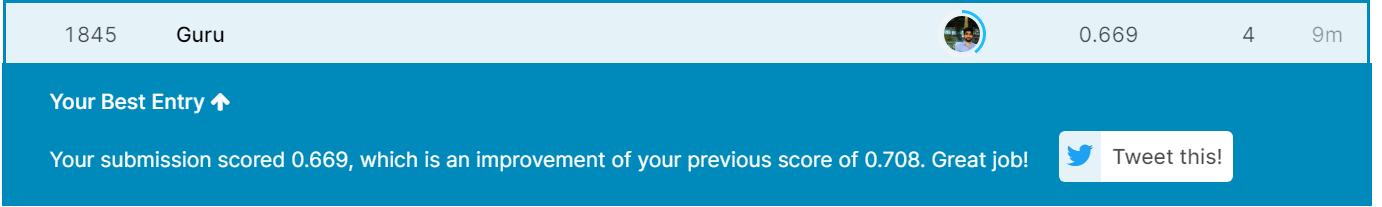